## 다국어 영수증 OCR을 위한 EDA

- 먼저, 기본적인 데이터의 특징이나 bbox 특징을 살펴본다
- 다음으로 텍스트에 대한 특징을 확인한다

### 기본 특징

#### 라이브러리 불러오기, 초기 경로/폰트 설정

In [1]:
import os
import re
import json
import platform
import numpy as np

from eda_module_installer import install_pandas, install_seaborn
install_pandas()
import pandas as pd

install_seaborn()
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.patches as patches

from tqdm import tqdm
#from tabulate import tabulate

from PIL import Image
from collections import Counter, defaultdict

from font_downloader import set_nanumgothic_font

In [2]:
os_name = platform.system()

if os_name == 'Windows':
    # 본인 로컬 경로로 지정
    root = 'C:/Users/yeyec/workspace/server3'
    plt.rcParams['font.family'] = 'Malgun Gothic'
else:
    root = '/data/ephemeral/home'
    font_path = set_nanumgothic_font(root)
    font_prop = fm.FontProperties(fname=font_path)

#### 데이터 불러오기

In [3]:
base_dir = root + '/code/data'
languages = ['chinese_receipt', 'japanese_receipt', 'thai_receipt', 'vietnamese_receipt']

image_widths = []
image_heights = []
words_per_image = []
bbox_widths = []
aspect_ratios = []
orientations = []
languages_list = []

In [4]:
for lang in languages:
    json_path = os.path.join(base_dir, lang, 'ufo', 'train.json')
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    for image_id, image_data in data['images'].items():
        # 이미지 크기
        img_w = image_data['img_w']
        img_h = image_data['img_h']
        image_widths.append(img_w)
        image_heights.append(img_h)

        # 언어 및 방향
        languages_list.append(lang)
        orientations.append(image_data.get('orientation', 'Horizontal'))

        # 단어 개수
        word_count = len(image_data['words'])
        words_per_image.append(word_count)

        # 각 단어의 BBox
        for word_info in image_data['words'].values():
            points = np.array(word_info['points'])
            x1, y1, x2, y2, x3, y3, x4, y4 = points.flatten()
            bbox_width = max(x1, x2, x3, x4) - min(x1, x2, x3, x4)
            bbox_height = max(y1, y2, y3, y4) - min(y1, y2, y3, y4)
            bbox_widths.append(bbox_width)
            
            if bbox_height > 0:
                aspect_ratios.append(bbox_width / bbox_height)

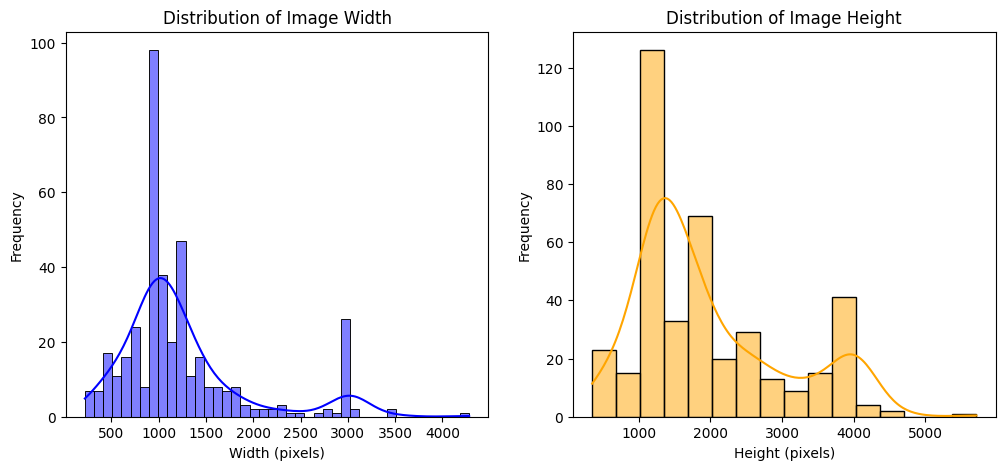

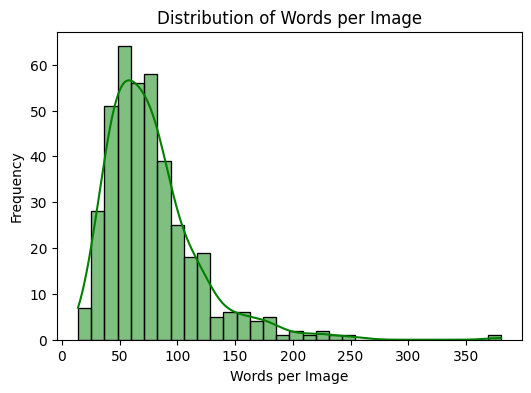

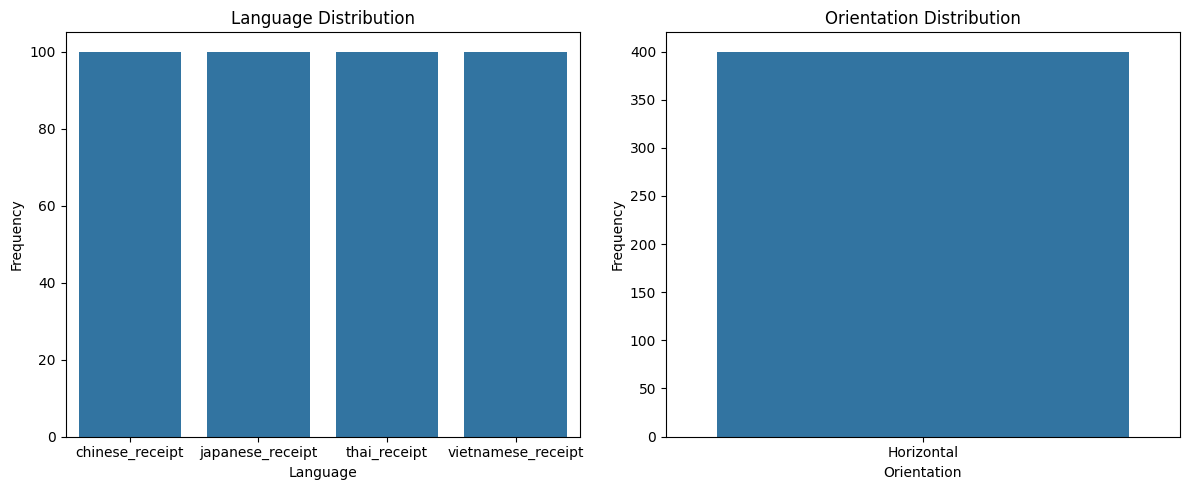

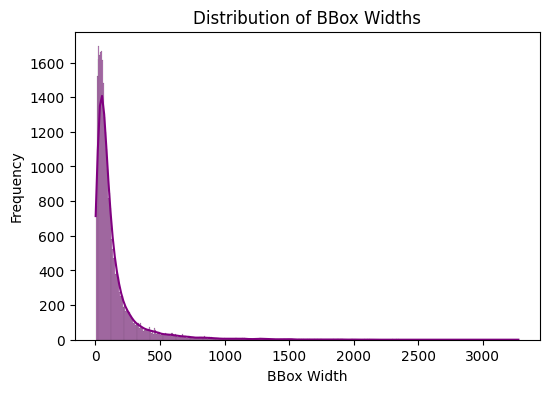

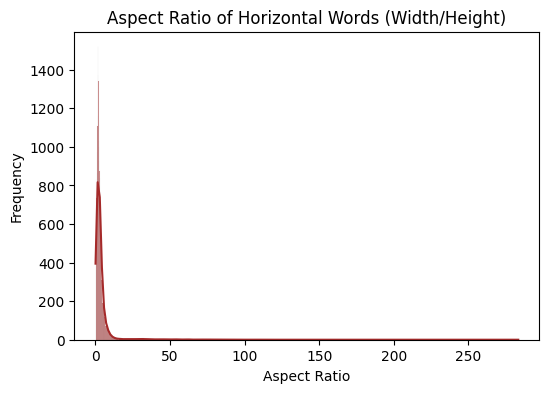

In [16]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(image_widths, kde=True, color='blue')
plt.title('Distribution of Image Width')
plt.xlabel('Width (pixels)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(image_heights, kde=True, color='orange')
plt.title('Distribution of Image Height')
plt.xlabel('Height (pixels)')
plt.ylabel('Frequency')
plt.show()

# 이미지 당 단어 개수 분포
plt.figure(figsize=(6, 4))
sns.histplot(words_per_image, kde=True, color='green')
plt.title('Distribution of Words per Image')
plt.xlabel('Words per Image')
plt.ylabel('Frequency')
plt.show()

# 태그 분포 (Language, Orientation)
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.countplot(x=languages_list, ax=axs[0])
axs[0].set_title('Language Distribution')
axs[0].set_xlabel('Language')
axs[0].set_ylabel('Frequency')

sns.countplot(x=orientations, ax=axs[1])
axs[1].set_title('Orientation Distribution')
axs[1].set_xlabel('Orientation')
axs[1].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

# BBox 크기 분포(너비 기준)
plt.figure(figsize=(6, 4))
sns.histplot(bbox_widths, kde=True, color='purple')
plt.title('Distribution of BBox Widths')
plt.xlabel('BBox Width')
plt.ylabel('Frequency')
plt.show()

# Horizontal 단어의 aspect ratio 분포 (가로/세로)
plt.figure(figsize=(6, 4))
sns.histplot(aspect_ratios, kde=True, color='brown')
plt.title('Aspect Ratio of Horizontal Words (Width/Height)')
plt.xlabel('Aspect Ratio')
plt.ylabel('Frequency')
plt.show()

In [6]:
bbox_counts = defaultdict(int)
vertical_bboxes = defaultdict(int)
bbox_ratios = defaultdict(list)
text_lengths = defaultdict(list)
rotation_angles = defaultdict(list)

In [12]:
for lang in languages:
    json_path = os.path.join(base_dir, lang, 'ufo', 'train.json')
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    for image_id, image_data in data['images'].items():
        for word_info in image_data['words'].values():
            points = np.array(word_info['points'])
            x1, y1, x2, y2, x3, y3, x4, y4 = points.flatten()
            
            # BBox 너비 및 높이 계산
            bbox_width = max(x1, x2, x3, x4) - min(x1, x2, x3, x4)
            bbox_height = max(y1, y2, y3, y4) - min(y1, y2, y3, y4)
            
            # 각 언어 당 BBox 개수
            bbox_counts[lang] += 1
            
            # 세로로 긴 BBox 개수
            if bbox_height > bbox_width:
                vertical_bboxes[lang] += 1
            
            # BBox 크기 비율 비교
            if bbox_height > 0:
                bbox_ratios[lang].append(bbox_width / bbox_height)
            
            # 텍스트 길이
            text = word_info.get('transcription', "")
            if text is None:
                text = "" 
            text_lengths[lang].append(len(text))
            
            # 방향 회전
            theta = word_info.get('orientation', 0)
            rotation_angles[lang].append(theta)

/tmp/ipykernel_161649/3519861165.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(bbox_counts.keys()), y=list(bbox_counts.values()), palette="viridis")


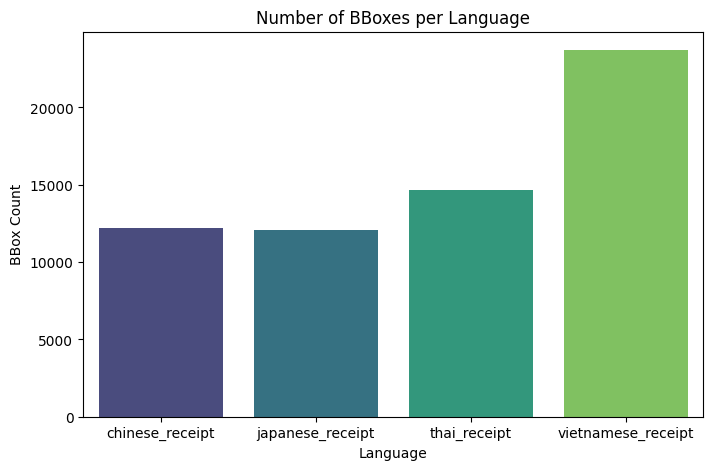

/tmp/ipykernel_161649/3519861165.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(vertical_bboxes.keys()), y=list(vertical_bboxes.values()), palette="viridis")


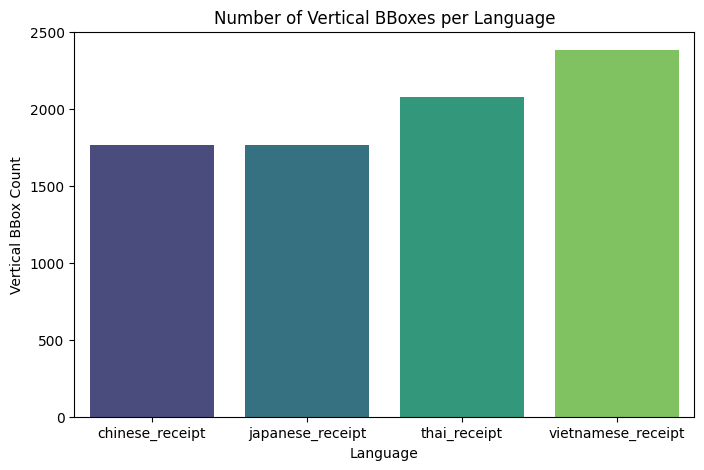

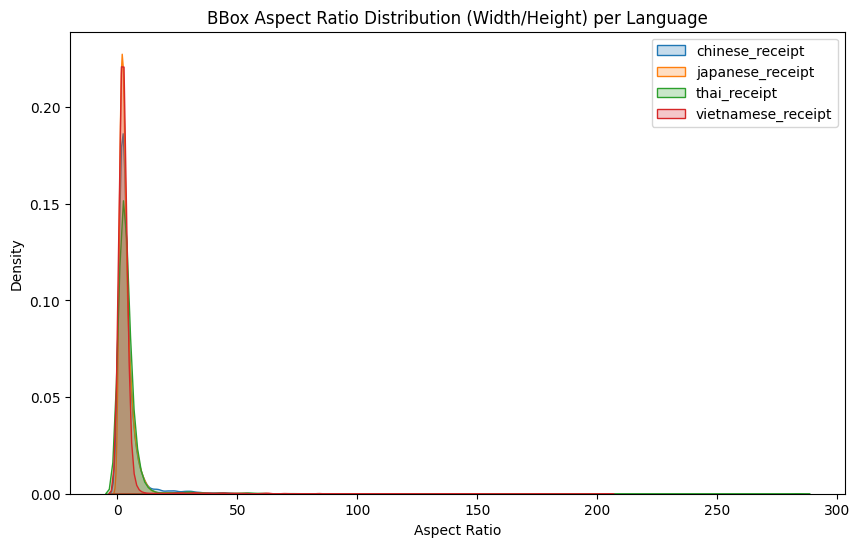

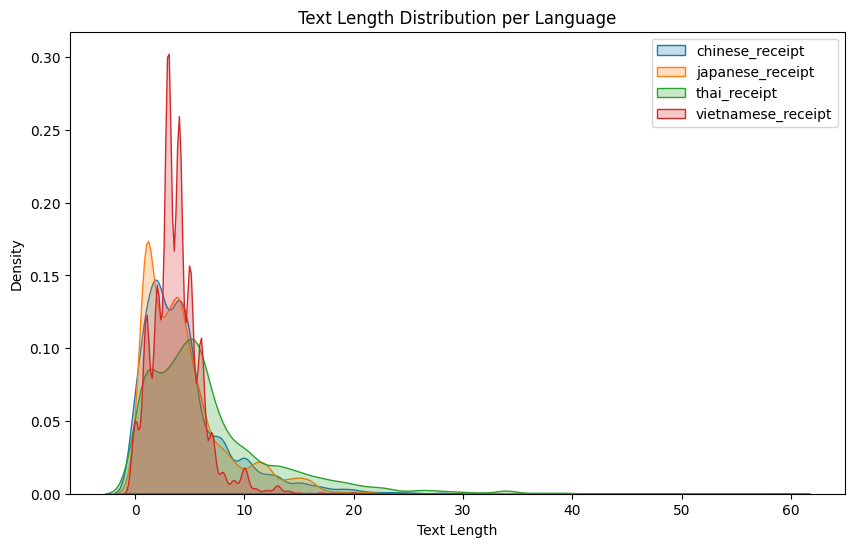

In [13]:
# 각 언어 당 BBox 개수
plt.figure(figsize=(8, 5))
sns.barplot(x=list(bbox_counts.keys()), y=list(bbox_counts.values()), palette="viridis")
plt.title("Number of BBoxes per Language")
plt.xlabel("Language")
plt.ylabel("BBox Count")
plt.show()

# 세로로 긴 BBox 개수
plt.figure(figsize=(8, 5))
sns.barplot(x=list(vertical_bboxes.keys()), y=list(vertical_bboxes.values()), palette="viridis")
plt.title("Number of Vertical BBoxes per Language")
plt.xlabel("Language")
plt.ylabel("Vertical BBox Count")
plt.show()

# BBox 크기 비율 (너비/높이) 비교
plt.figure(figsize=(10, 6))
for lang, ratios in bbox_ratios.items():
    sns.kdeplot(ratios, label=lang, fill=True)
plt.title("BBox Aspect Ratio Distribution (Width/Height) per Language")
plt.xlabel("Aspect Ratio")
plt.ylabel("Density")
plt.legend()
plt.show()

# 텍스트 길이 분포
plt.figure(figsize=(10, 6))
for lang, lengths in text_lengths.items():
    sns.kdeplot(lengths, label=lang, fill=True)
plt.title("Text Length Distribution per Language")
plt.xlabel("Text Length")
plt.ylabel("Density")
plt.legend()
plt.show()

In [19]:
from skimage import color
import cv2

contrast_ratios = []
rotation_angles = []
text_lengths = []
text_positions = []

def calculate_contrast(image, bbox):
    # BBox 내부 영역을 가져와 대비 계산
    x_min, y_min = np.min(bbox, axis=0)
    x_max, y_max = np.max(bbox, axis=0)
    roi = image[y_min:y_max, x_min:x_max]
    gray_roi = color.rgb2gray(roi)  # 그레이스케일 변환

    contrast = gray_roi.max() - gray_roi.min()  # 대비 계산
    return contrast

In [21]:

for lang in languages:
    json_path = os.path.join(base_dir, lang, 'ufo', 'train.json')
    img_dir = os.path.join(base_dir, lang, 'img', 'train')
    
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    for image_id, image_data in data['images'].items():
        img_path = os.path.join(img_dir, image_id)
        image = cv2.imread(img_path)
        if image is None:
            continue
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # RGB로 변환

        for word_info in image_data['words'].values():
            points = np.array(word_info['points']).astype(int)
            # 텍스트 대비도 계산
            contrast = calculate_contrast(image, points)
            contrast_ratios.append(contrast)
            
            # 방향 회전 각도 수집
            theta = word_info.get('orientation', 0)
            rotation_angles.append(theta)

            # 텍스트 길이 수집
            text = word_info.get('transcription', "")
            if text is not None:
                text_lengths.append(len(text))

            # 텍스트 위치 수집 (bbox 중심점 좌표)
            x_center = (points[:, 0].min() + points[:, 0].max()) / 2
            y_center = (points[:, 1].min() + points[:, 1].max()) / 2
            text_positions.append((x_center, y_center))

ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(contrast_ratios, kde=True)
plt.title("Text Contrast Distribution")
plt.xlabel("Contrast Ratio")
plt.ylabel("Frequency")
plt.show()

# 방향 회전 각도 분포 시각화
plt.figure(figsize=(10, 5))
sns.histplot(rotation_angles, kde=True)
plt.title("Text Rotation Angle Distribution")
plt.xlabel("Rotation Angle (radians)")
plt.ylabel("Frequency")
plt.show()

# 텍스트 길이 분포 시각화
plt.figure(figsize=(10, 5))
sns.histplot(text_lengths, kde=True)
plt.title("Text Length Distribution")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()

# 텍스트 위치 분포 시각화
x_positions, y_positions = zip(*text_positions)
plt.figure(figsize=(10, 10))
plt.hexbin(x_positions, y_positions, gridsize=50, cmap="Blues")
plt.colorbar(label="Frequency")
plt.title("Text Position Distribution in Image")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.gca().invert_yaxis()
plt.show()